# Clustering Destinations
## Applied Data Science course - Capstone project

### Installing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import html

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
!pip install foursquare
import foursquare

In [3]:
!pip install geocoder
import geocoder

     |████████████████████████████████| 102kB 12.2MB/s ta 0:00:01


In [4]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                       

### Parsing city data from wikipedia

In [5]:
WIKI_URL = 'https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors'

cities = pd.DataFrame(columns=['City', 'Country'])

soup = BeautifulSoup(requests.get(WIKI_URL).text, 'html.parser')
for row in soup.select_one('table.wikitable tbody').find_all('tr'):
    cols = row.find_all('td')
    if len(cols) is 0:
        continue
    cities = cities.append({'City': cols[2].get_text().strip(), 'Country': cols[3].get_text().strip()}, ignore_index=True)



In [6]:
cities.shape

(139, 2)

### Gathering location data for the cities

In [7]:
MAX_RETRIES = 10
def get_lat_lon(city, country):
    
    retries = MAX_RETRIES
    location = None
    while retries > 0 and location is None:
        location = geocoder.osm('{}, {}'.format(city, country)).latlng
        retries -= 1
        
    if location is None:        
        return { 'Latitude': None, 'Longitude': None }

    return { 'Latitude': location[0], 'Longitude': location[1] }



In [8]:
lat_lon_df = pd.DataFrame(columns=['Latitude', 'Longitude'])
for i, row in cities.iterrows():
    lat_lon_df = lat_lon_df.append(get_lat_lon(row['City'], row['Country']), ignore_index=True)
cities_with_location = pd.concat([cities, lat_lon_df], axis=1, sort=False)

In [9]:
cities_with_location.shape

(139, 4)

In [10]:
cities_with_location.head()

,City,Country,Latitude,Longitude
0,Hong Kong,Hong Kong,22.279328,114.162813
1,Bangkok,Thailand,13.754253,100.493087
2,London,United Kingdom,51.507322,-0.127647
3,Macau,Macau,-5.113366,-36.634996
4,Singapore,Singapore,1.357107,103.819499


In [11]:
cities_with_location.dropna(inplace=True)

In [12]:
cities_with_location.shape

(139, 4)

### Visualizing cities

In [13]:
import html

world_map = folium.Map(location=[0, 0], zoom_start=2)

for lat, lon, city, country in zip(cities_with_location.Latitude, cities_with_location.Longitude, cities_with_location.City, cities_with_location.Country):
    folium.features.Marker(
        [lat, lon],
        popup=folium.Popup('<h3>{}</h3><h4>{}</h4>'.format(html.escape(city), html.escape(country))),
    ).add_to(world_map)

world_map

The visualization of the cities shows that the majority of these cities are located near sea shores.

### Getting venue data for the cities

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
fs_client = foursquare.Foursquare(client_id=FOURSQUARE_CLIENT_ID, client_secret=FOURSQUARE_CLIENT_SECRET)

In [16]:
def get_venues(city, country, lat, lon):
    try:
        venues = pd.DataFrame(columns=['City', 'Country', 'Name', 'Category', 'Latitude', 'Longitude', 'City_Latitude', 'City_Longitude'])
        offset = 0
        limit = 50
        while True:
            response = fs_client.venues.explore(params={'near': '{}, {}'.format(city, country), 'time': 'any', 'day': 'any', 'radius': 10000, 'limit': limit, 'offset': offset})
            totalResults = min(response['totalResults'], 250)
            print("Getting venues for", city, country, offset, limit, totalResults)
            for v in response['groups'][0]['items']:
                venues = venues.append({
                    'City': city,
                    'Country': country,
                    'Name': v['venue']['name'],
                    'Category': v['venue']['categories'][0]['pluralName'],
                    'Latitude': v['venue']['location']['lat'],
                    'Longitude': v['venue']['location']['lng'],
                    'City_Latitude': lat,
                    'City_Longitude': lon
                }, ignore_index=True)
            offset += limit
            if offset > totalResults:
                break
    except:
        print('An error occured for', city, country)
    return venues

In [66]:
venues_with_cities = pd.DataFrame(columns=['City', 'Country', 'Name', 'Category', 'Latitude', 'Longitude', 'City_Latitude', 'City_Longitude'])

for lat, lon, city, country in zip(cities_with_location.Latitude, cities_with_location.Longitude, cities_with_location.City, cities_with_location.Country):
    venues_with_cities = pd.concat([venues_with_cities, get_venues(city, country, lat, lon)], axis=0)

venues_with_cities = venues_with_cities.reset_index().drop('index', axis=1)
    
venues_with_cities.head()


Getting venues for Hong Kong Hong Kong 0 50 237
Getting venues for Hong Kong Hong Kong 50 50 237
Getting venues for Hong Kong Hong Kong 100 50 237
Getting venues for Hong Kong Hong Kong 150 50 237
Getting venues for Hong Kong Hong Kong 200 50 237
Getting venues for Bangkok Thailand 0 50 212
Getting venues for Bangkok Thailand 50 50 212
Getting venues for Bangkok Thailand 100 50 212
Getting venues for Bangkok Thailand 150 50 212
Getting venues for Bangkok Thailand 200 50 212
Getting venues for London United Kingdom 0 50 238
Getting venues for London United Kingdom 50 50 238
Getting venues for London United Kingdom 100 50 238
Getting venues for London United Kingdom 150 50 238
Getting venues for London United Kingdom 200 50 238
Getting venues for Macau Macau 0 50 28
Getting venues for Singapore Singapore 0 50 232
Getting venues for Singapore Singapore 50 50 232
Getting venues for Singapore Singapore 100 50 232
Getting venues for Singapore Singapore 150 50 232
Getting venues for Singapore

,City,Country,Name,Category,Latitude,Longitude,City_Latitude,City_Longitude
0,Hong Kong,Hong Kong,Four Seasons Hotel Hong Kong (香港四季酒店),Hotels,22.286554,114.156929,22.279328,114.162813
1,Hong Kong,Hong Kong,Mandarin Grill + Bar (文華扒房＋酒吧),Steakhouses,22.281928,114.159408,22.279328,114.162813
2,Hong Kong,Hong Kong,Pure Yoga,Yoga Studios,22.283022,114.155674,22.279328,114.162813
3,Hong Kong,Hong Kong,Mandarin Oriental Hong Kong (香港文華東方酒店),Hotels,22.281857,114.159382,22.279328,114.162813
4,Hong Kong,Hong Kong,Samsen (泰館),Thai Restaurants,22.285082,114.152286,22.279328,114.162813


In [67]:
venue_count = venues_with_cities.groupby('City').count()[['Category']].sort_values(by='Category')
venue_count

,Category
City,
Mecca,1
Medina,9
Macau,28
Guilin,37
Ha Long,52
Agra,62
Tianjin,66
Florence,67
Zhuhai,69


Checking the number of venues for each city reveals that a few cities have insuficient data. These cities should be omitted form the classification.

In [68]:
cities_to_drop = venue_count[venue_count.Category < 10].index.values
cities_to_drop

array(['Mecca', 'Medina'], dtype=object)

In [69]:
category_count = venues_with_cities.groupby('Category').count()[['City']].sort_values(by='City')
category_count_display = category_count[category_count.City > 10]

<BarContainer object of 288 artists>

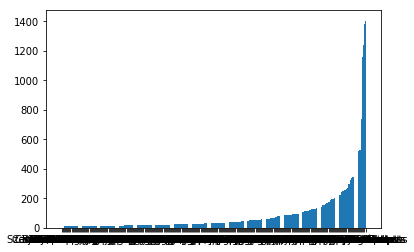

In [70]:
plt.bar(category_count_display.index, category_count_display.City)

In [71]:
category_count_display

,City
Category,
Buildings,11
Szechuan Restaurants,11
Fields,11
Temples,11
Cycle Studios,11
Cricket Grounds,11
Souvlaki Shops,11
Metro Stations,11
Cantonese Restaurants,11


In [114]:
categories_to_drop = category_count[category_count.City < 5].append(category_count[category_count.City > 600]).index.values
categories_to_drop

array(['Abruzzo Restaurants', 'College Administrative Buildings',
       'College Basketball Courts', 'College Cafeterias',
       'College Libraries', 'College Quads', 'College Residence Halls',
       'College Stadiums', 'College Theaters', 'Colombian Restaurants',
       'Pool Halls', 'Confucian Temples', 'Pilates Studios',
       'Cooking Schools', 'Pide Places', 'Piano Bars', 'Private Schools',
       'Punjabi Restaurants', 'RV Parks', 'Racecourses',
       'Bratwurst Joints', 'Ski Areas', 'Burmese Restaurants',
       'Shanxi Restaurants', 'Business Centers', 'Schools',
       'Satay Restaurants', 'Photography Labs', 'Samba Schools',
       'Rugby Pitches', 'Roman Restaurants', 'Cha Chaan Tengs',
       'Chinese Aristocrat Restaurants', 'Chinese Breakfast Places',
       'Rental Services', 'Circus Schools', 'Rugby Stadiums',
       'Brasseries', 'Pet Services', 'Dairy Stores', 'Lighting Stores',
       'Language Schools', 'Karnataka Restaurants', 'Karaoke Boxes',
       'Iraqi Re

After examining the category data I decided to remove venues fromt the list that appear in too few places and the ones that are so common that they become irrelevant for determining differences between cities.

In [115]:
drop_indexes = []
for i, row in venues_with_cities.iterrows():
    if row.City in cities_to_drop or row.Category in categories_to_drop:
        drop_indexes.append(i)

print("Dropping {} venues from the total of {}".format(len(drop_indexes), venues_with_cities.shape[0]))
venues_with_cities_filtered  = venues_with_cities.drop(drop_indexes)
venues_with_cities_filtered.shape

Dropping 6447 venues from the total of 26924


(20477, 8)

In [121]:
cities_aggregated = pd.get_dummies(venues_with_cities_filtered[['City', 'Country', 'City_Latitude', 'City_Longitude', 'Category']], columns=['Category'], prefix='', prefix_sep='').groupby(['City', 'Country', 'City_Latitude', 'City_Longitude']).mean().reset_index()
cities_aggregated.head()

,City,Country,City_Latitude,City_Longitude,Accessories Stores,Afghan Restaurants,African Restaurants,Airport Lounges,Airport Services,Airport Terminals,...,Wine Shops,Wineries,Wings Joints,Xinjiang Restaurants,Yakitori Restaurants,Yoga Studios,Yoshoku Restaurants,Yunnan Restaurants,Zoo Exhibits,Zoos
0,Abu Dhabi,United Arab Emirates,24.474796,54.370576,0.0,0.000000,0.007246,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,Accra,Ghana,5.560014,-0.205744,0.0,0.000000,0.084746,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,Agra,India,27.175255,78.009816,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,Amman,Jordan,31.951569,35.923963,0.0,0.007812,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.007812,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,Amsterdam,Netherlands,52.372760,4.893604,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.011364,0.0,0.000000,0.0,0.0,0.017045,0.0,0.0,0.0,0.005682


In [122]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

Text(0.5, 0, 'Number of clusters *k*')

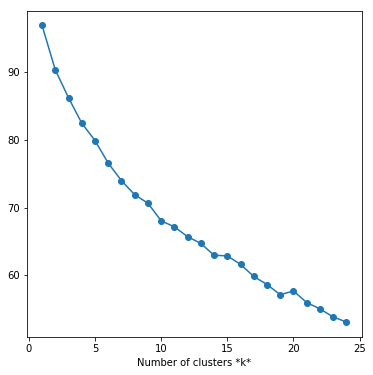

In [124]:
X = normalize(cities_aggregated.iloc[:,4:])

sse = []
list_k = list(range(1,25))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')

Although no clear elbow is visible, the slope of the curve is changin around K = 11. Based on this I will choose 11 as the cluster number.

In [125]:
clusters = KMeans(n_clusters=11).fit(X)
clusters.labels_

array([ 1,  7,  3,  1,  8,  9,  1,  6,  9,  3, 10,  4, 10, 10,  1,  2,  8,
        8,  4,  4,  2,  8,  1,  6,  9,  7,  7,  7,  3, 10,  5,  6,  7,  9,
        0,  7,  6,  1,  3,  0,  0,  4,  7,  4,  9,  8,  4,  5,  4,  7,  7,
        9,  4,  7, 10,  0, 10, 10,  9,  6,  0,  1,  3, 10, 10,  1,  7, 10,
        3,  0,  4, 10,  5,  6,  4,  4,  2,  8,  9,  4, 10,  0,  9,  8,  9,
        8,  4,  8,  2,  3,  2,  4,  8,  9,  6,  5,  8,  0, 10,  8,  0,  9,
        2,  3,  0,  7,  8,  0,  9,  1,  8,  8,  9,  6, 10, 10, 10,  9,  4,
        2,  9,  8, 10,  4,  9,  7,  5,  8,  9,  8,  4,  4,  8,  7,  7,  7,
        4], dtype=int32)

In [126]:
cities_clustered = cities_aggregated.copy()
cities_clustered['Cluster'] = pd.DataFrame(clusters.labels_)
cities_clustered = cities_clustered.dropna()
cities_clustered

,City,Country,City_Latitude,City_Longitude,Accessories Stores,Afghan Restaurants,African Restaurants,Airport Lounges,Airport Services,Airport Terminals,...,Wineries,Wings Joints,Xinjiang Restaurants,Yakitori Restaurants,Yoga Studios,Yoshoku Restaurants,Yunnan Restaurants,Zoo Exhibits,Zoos,Cluster
0,Abu Dhabi,United Arab Emirates,24.474796,54.370576,0.000000,0.000000,0.007246,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,Accra,Ghana,5.560014,-0.205744,0.000000,0.000000,0.084746,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7
2,Agra,India,27.175255,78.009816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,Amman,Jordan,31.951569,35.923963,0.000000,0.007812,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,Amsterdam,Netherlands,52.372760,4.893604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.017045,0.000000,0.000000,0.000000,0.005682,8
5,Antalya,Turkey,36.927965,30.727687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
6,Athens,Greece,37.983941,23.728305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
7,Atlanta,United States,33.749099,-84.390185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.021164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
8,Auckland,New Zealand,-36.852095,174.763180,0.000000,0.000000,0.006173,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006173,9
9,Bangalore,India,12.979120,77.591300,0.000000,0.005495,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.005495,0.000000,0.000000,0.000000,0.000000,3


In [129]:
cluster_map = folium.Map([0, 0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(11)
ys = [i + x + (i*x)**2 for i in range(11)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for city, lat, lon, cluster in zip(cities_clustered['City'], cities_clustered['City_Latitude'], cities_clustered['City_Longitude'], cities_clustered['Cluster'], ):
    label = folium.Popup(city + '(Cluster: ' + str(cluster) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1).add_to(cluster_map)

    

cluster_map

Showing the clusters location around the globe helps us in evaluating the model. 

The clusters clearly show some corelation with the geographical location of the cities in the cluster. This is a good sign, because in tourism we expect this.

Let's examine the clusters:

In [146]:
def get_categories(city):
    return city.drop('Cluster').drop('City_Longitude').drop('City_Latitude').T.drop('Country').drop('City').sort_values(ascending=False).reset_index()['index'].values

In [147]:
from collections import Counter
clusters = cities_clustered['Cluster'].unique()
clusters.sort()
for cluster in clusters:
    categories = []
    for i, city in cities_clustered[cities_clustered['Cluster'] == cluster].iterrows():
        categories.extend(get_categories(city))
    print('Top categories for Cluster', cluster)
    print(Counter(categories).most_common(10))

Top categories for Cluster 0
[('Vietnamese Restaurants', 11), ('Resorts', 11), ('Beaches', 11), ('Spas', 11), ('Restaurants', 11), ('BBQ Joints', 11), ('Hotel Bars', 11), ('Mountains', 11), ('Caves', 11), ('Burger Joints', 11)]
Top categories for Cluster 1
[('Middle Eastern Restaurants', 9), ('Resorts', 9), ('Beaches', 9), ('Shopping Malls', 9), ('Restaurants', 9), ('Supermarkets', 9), ('Steakhouses', 9), ('Hotel Bars', 9), ('Japanese Restaurants', 9), ('Pizza Places', 9)]
Top categories for Cluster 2
[('Ice Cream Shops', 7), ('Pizza Places', 7), ('Bookstores', 7), ('Bars', 7), ('Falafel Restaurants', 7), ('Gourmet Shops', 7), ('Monuments / Landmarks', 7), ('Wine Bars', 7), ('Breweries', 7), ('Beer Bars', 7)]
Top categories for Cluster 3
[('Indian Restaurants', 8), ('Historic Sites', 8), ('Resorts', 8), ('Fast Food Restaurants', 8), ('Multicuisine Indian Restaurants', 8), ('Markets', 8), ('Pizza Places', 8), ('Restaurants', 8), ('Arts & Crafts Stores', 8), ('Train Stations', 8)]
Top ca

In [139]:
cities_clustered['Cluster'].unique()

array([ 1,  7,  3,  8,  9,  6, 10,  4,  2,  5,  0])

In [148]:
clusters = cities_clustered['Cluster'].unique()
clusters.sort()
for cluster in clusters:
    cities = []
    for i, city in cities_clustered[cities_clustered['Cluster'] == cluster].iterrows():
        cities.append(city.City)
    print('Cities in Cluster', cluster)
    print(cities)

Cities in Cluster 0
['Da Nang', 'Denpasar', 'Dubai', 'Heraklion', 'Hurghada', 'Krabi', 'Marrakesh', 'Pattaya', 'Phuket', 'Punta Cana', 'Rhodes']
Cities in Cluster 1
['Abu Dhabi', 'Amman', 'Athens', 'Beirut', 'Cairo', 'Dammam', 'Istanbul', 'Jerusalem', 'Riyadh']
Cities in Cluster 2
['Berlin', 'Budapest', 'London', 'Moscow', 'Munich', 'Prague', 'Stockholm']
Cities in Cluster 3
['Agra', 'Bangalore', 'Chennai', 'Delhi', 'Jaipur', 'Kolkata', 'Mumbai', 'Pune']
Cities in Cluster 4
['Barcelona', 'Brussels', 'Bucharest', 'Dublin', 'Düsseldorf', 'Frankfurt am Main', 'Geneva', 'Hamburg', 'Kraków', 'Lima', 'Lisbon', 'Madrid', 'Montevideo', 'Muğla', 'Sofia', 'Tehran', 'Vienna', 'Warsaw', 'Zürich']
Cities in Cluster 5
['Chiba', 'Fukuoka', 'Kyoto', 'Osaka', 'Tokyo']
Cities in Cluster 6
['Atlanta', 'Cancún', 'Chicago', 'Dallas', 'Houston', 'Las Vegas', 'Orlando', 'San Jose']
Cities in Cluster 7
['Accra', 'Casablanca', 'Cebu City', 'Chengdu', 'Colombo', 'Dalian', 'Durban', 'Guangzhou', 'Guilin', 'Hangz